## CAR Model for crash prediction
### Developed by: bpben

In [1]:
import re
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import describe

In [2]:
import json

In [3]:
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as tt
import theano.sparse
import scipy.sparse

### Data processing
The approach here is to create 3 time-lag features:

1. crashes in the past week
2. crashes in the past month
3. crashes in the past quarter (three months)
4. average crashes per week up to target week

All features except 4 are calculated to exclude one another.  That is, crashes in the past month does not include the past week's crashes.  Crashes in the past quarter do not include the past month.

In [4]:
SEG_CHARS = ['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']

In [5]:
# Read in data
data = pd.read_csv('../data/processed/vz_predict_dataset.csv.gz', compression='gzip', dtype={'segment_id':'str'})
data.sort_values(['segment_id', 'week'], inplace=True)

In [6]:
# get segments with non-zero crashes
data_nonzero = data.set_index('segment_id').loc[data.groupby('segment_id').crash.sum()>0]
data_nonzero.reset_index(inplace=True)

In [7]:
def format_crash_data(data, col, target):
    """ formats crash data for train/test 
    target: week to predict (make into binary target)
        must be >4 months in
    gets previous week count, previous month count, previous quarter count, avg per week
    
    """
    assert target>16
    pre_week = target - 1
    pre_month = range(pre_week-4, target)
    pre_quarter = range(pre_month[0]-12, target)
    all_prior_weeks = range(1, target)
    
    # week interval for each segment
    # full range = pre_quarter : target
    sliced = data.loc[(slice(None),slice(1, target)),:]
    week_data = sliced[col].unstack(1)
    week_data.reset_index(level=1, inplace=True)
    
    # aggregate
    week_data['pre_month'] = week_data[pre_month].sum(axis=1)
    week_data['pre_quarter'] = week_data[pre_quarter].sum(axis=1)
    week_data['pre_week'] = week_data[pre_week]
    # avg as of target week
    week_data['avg_week'] = week_data[all_prior_weeks].apply(
        lambda x: x.sum() / len(all_prior_weeks), axis=1
    )
    
    # binarize target
    #week_data['target'] = (week_data[target]>0).astype(int)
    week_data['target'] = week_data[target]
    
    return(week_data[['segment_id','target', 'pre_week', 
                      'pre_month', 'pre_quarter', 'avg_week']])

In [20]:
# arbitrarily choosing week = 50
crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','week']), 'crash', 50)
#crash_lags = format_crash_data(data.set_index(['segment_id','week']), 'crash', 50)

In [21]:
#data_segs = data_nonzero.groupby('segment_id')[SEG_CHARS].max()
data_segs = data.groupby('segment_id')[SEG_CHARS].max()
data_segs.reset_index(inplace=True)
# add crash lags to segments
data_model = crash_lags.merge(data_segs, on='segment_id')

In [22]:
# read in adj
adj = pd.read_csv('../data/processed/adjacency_info.csv', dtype={'segment_id':'str'})
# only include adj that are in data model
adj = adj[adj.segment_id.isin(data_model.segment_id)]
# make adj into form in example
adj_mat = adj.merge(adj, on='orig_id')
# drop self in list
adj_mat = adj_mat[adj_mat.segment_id_x!=adj_mat.segment_id_y]
# get adj in the form needed for pymc3 implementtion
adj_mat = adj_mat.groupby('segment_id_x').segment_id_y.unique().reset_index()
adj_mat.columns = ['segment_id', 'adj']

In [23]:
# add adjacency
data_model = data_model.merge(adj_mat, on='segment_id')

In [24]:
seg_unique = sorted(np.unique(np.concatenate(data_model.adj.values)))

In [25]:
# seg needs to be an integer index, not string
data_model['adj_index'] = data_model.adj.apply(lambda x: np.array([seg_unique.index(i) for i in x],
                                                                 dtype=np.int))

In [26]:
# prepare data
N = len(data_model) # number of observations
O = data_model.target

In [27]:
# Wplus = number of adjacent roads, can just calculate that as column
data_model['wplus'] = data_model['adj'].apply(len)
data_model['weights'] = data_model['wplus'].apply(lambda x: np.ones(x,))

In [28]:
# matrix to calculate mu
maxwz = data_model.wplus.max()
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(data_model['adj_index'].values):
    amat2[i, a] = 1
    wmat2[i, a] = data_model.wplus.iloc[i]

In [29]:
amat = data_model.adj_index.values
wmat = data_model.weights.values
O = data_model.target.values

## working CAR class and model

In [73]:
class CAR(pm.distributions.distribution.Continuous):
    def __init__(self, alpha, adjacency, *args, **kwargs):
        if not isinstance(adjacency, np.ndarray):
            raise ValueError("Adjacency matrix is not an ndarray.")
        n, m = adjacency.shape
        if n != m or np.any(adjacency != adjacency.T):
            raise ValueError('Adjacency matrix must be symmetric.')
        if 'shape' in kwargs and kwargs['shape'] == n:
            raise ValueError('Invalid shape: Must match matrix dimension.')
        kwargs['shape'] = n
        super(CAR, self).__init__(*args, **kwargs)
        self.n = n
        self.alpha = tt.as_tensor_variable(alpha)
        adjacency_sparse = scipy.sparse.csr_matrix(adjacency)
        self.adjacency = theano.sparse.as_sparse_variable(adjacency_sparse)
        self.neighbors = tt.as_tensor_variable(adjacency.sum(0))
        self.mean = tt.zeros(n)
        self.median = self.mean
        adj = adjacency.astype('d').copy()
        sqrt_neighbors = 1 / np.sqrt(adjacency.sum(0))
        adj[:] *= sqrt_neighbors[:, None]
        adj[:] *= sqrt_neighbors[None, :]
        self.eigs = scipy.linalg.eigvalsh(adj)

    def logp(self, x):
        Wx = theano.sparse.dot(self.adjacency, x.reshape((self.n, 1)))
        tau_dot_x = self.neighbors * x - self.alpha * Wx.ravel()
        logdet = tt.log(1 - self.alpha * self.eigs).sum()
        logp = 0.5 * (logdet - tt.dot(x, tau_dot_x))
        return logp

with pm.Model() as model:
    b0 = pm.Normal('intercept', mu=5.4, sd=2)
    b1 = pm.Cauchy('avg_week', alpha=0, beta=2)

    # random effect precision parameter
    sd = pm.HalfCauchy('sd', beta=2)
    # strength of spatial correlation
    p = pm.Uniform('p', lower=0, upper=1)
    phi = CAR('mu_phi', alpha=p, adjacency=amat2)
    
    theta = pm.invlogit(b0 + b1 * data_model.avg_week.values + sd * phi)
    #mu = tt.exp(b0 + b1 * data_model.avg_week.values + sd * phi)
    
    obs_crash = pm.Binomial('obs_crash', n=N, p=theta, observed=O)
    #result = pm.Poisson('Yi', mu=mu, observed=O)

    
    trace = pm.sample(2000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 655.22: 100%|██████████| 200000/200000 [02:19<00:00, 1429.95it/s]    
Finished [100%]: Average ELBO = 653.89
100%|██████████| 2000/2000 [07:06<00:00,  4.69it/s] 


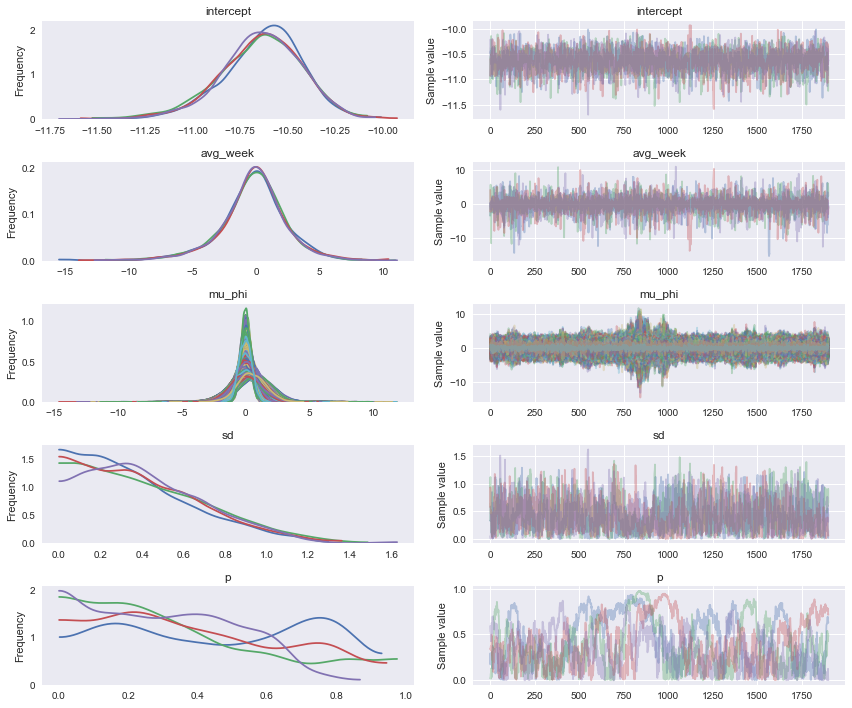

In [65]:
pm.traceplot(trace[100:]);

In [79]:
from sklearn.metrics import roc_auc_score

In [81]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=5000)

100%|██████████| 5000/5000 [00:35<00:00, 139.33it/s]


In [82]:
pred_y = np.mean(ppc['obs_crash'], axis=0)

In [83]:
# convert target to binary
O_int = (O>0).astype(int)
roc_auc_score(O_int, pred_y)

0.8048399451701338

In [87]:
#MAE
print "MAE is : {}".format(
    np.mean(abs(pred_y - O_int))
)

MAE is : 0.0621749809306


In [97]:
# output predicted probabilities
pd.DataFrame(zip(data_model['segment_id'].values, pred_y),
            columns=['segment_id', 'pred']).to_csv('../data/processed/car_preds.csv')

### non-working attempt to include other features

In [59]:
#data_sub.adj_index#.nunique()

In [54]:
data_sub = data_model.sample(frac=.1).copy(deep=True)
N_sub = data_sub.shape[0]
# recode index
seg_unique = sorted(np.unique(np.concatenate(data_sub.adj.values)))
data_sub['adj_index'] = data_sub.adj.apply(lambda x: np.array([seg_unique.index(i) for i in x],
                                                                 dtype=np.int))
print len(data_sub)
amat_sub = np.zeros((N_sub, N_sub), dtype='int32')
for i, a in enumerate(data_sub['adj_index'].values):
    amat_sub[i, a] = 1

131


IndexError: index 184 is out of bounds for axis 1 with size 131

In [50]:
with pm.Model() as model_sub:
    b0 = pm.Normal('intercept', mu=5.4, sd=2)
    b1 = pm.Cauchy('avg_week', alpha=0, beta=2)
    b2 = pm.Cauchy('pre_week', alpha=0, beta=2)
    b3 = pm.Cauchy('pre_month', alpha=0, beta=2)
    b4 = pm.Cauchy('pre_q', alpha=0, beta=2)

    # random effect precision parameter
    sd = pm.HalfCauchy('sd', beta=2)
    # strength of spatial correlation
    p = pm.Uniform('p', lower=0, upper=1)
    phi = CAR('mu_phi', alpha=p, adjacency=amat_sub)
    
    mu = tt.exp(b0 + b1 * data_sub.avg_week.values +\
                b1 * data_sub.avg_week.values +\
                b2 * data_sub.pre_week.values + \
                b3 * data_sub.pre_month.values + \
                b4 * data_sub.pre_quarter.values + sd * phi)
    
    result = pm.Poisson('Yi', mu=mu, observed=data_sub.target.values)
    
    trace = pm.sample(2000, tune=1000, njobs=4)

ValueError: Adjacency matrix must be symmetric.